In [9]:
# execute this for the 1st time
# !pip install -r example-requirements.txt 

# download file 
# !wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

In [125]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import pandas as pd

Opening data file

In [11]:
fname = join(os.getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

print (type(mat_contents))
mat_contents.keys()

<class 'dict'>


dict_keys(['__header__', '__version__', '__globals__', 'dataset', 'labels'])

Separating parameters and labels

In [12]:
print ('dataset: ',mat_contents['dataset'].shape)
print ('labels: ',mat_contents['labels'].shape)

dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases, experiments

y = mat_contents['labels'].reshape(Nc)
print ('y: ',len(y))
y[::50]

dataset:  (8192, 5, 850)
labels:  (1, 850)
y:  850


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=uint8)

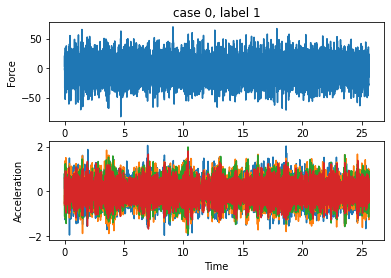

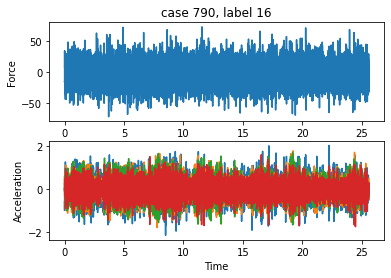

In [13]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

Transposing the channel dat: Ch(i) > X(i), i in {2,3,4,5}

In [14]:
X2 = Ch2.transpose()
X3 = Ch3.transpose()
X4 = Ch4.transpose()
X5 = Ch5.transpose()

print (Ch2.shape, X2.shape)

print (X2[15])
print (Ch2[:,15])


(8192, 850) (850, 8192)
[ 0.08160464  0.2051324   0.04151391 ...  0.69319308 -0.02829366
 -1.00325987]
[ 0.08160464  0.2051324   0.04151391 ...  0.69319308 -0.02829366
 -1.00325987]


Fitting AR model and building XR matrix

In [124]:
modelOrder = 30

XR = []
X2R = []
X3R = []
X4R = []
X5R = []

for case in X2: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    X2R.append(res.params)
for case in X3: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    X3R.append(res.params)
for case in X4: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    X4R.append(res.params)
for case in X5: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    X5R.append(res.params)

XR = np.concatenate([X2R, X3R, X4R, X5R], axis=1)
XR.shape

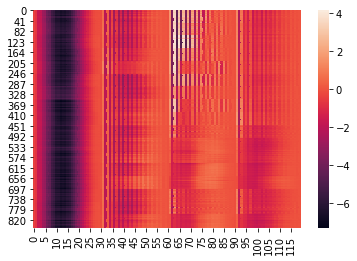

In [189]:
df = pd.DataFrame(XR)
df2 = df.copy()

for i in range(len(XR[0])):
    df2.iloc[:,i] = y

sns.heatmap(df)



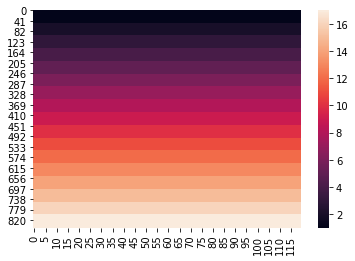

In [190]:
sns.heatmap(df2)